In [82]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox





In [83]:
df = pd.read_csv("/content/exchange_rate.csv")
print(df.columns)

# First col-> date
df.iloc[:,0] = pd.to_datetime(df.iloc[:,0],errors='coerce')
df = df.rename(columns={df.columns[0]:'date', df.columns[1]:'Ex_rate'})
df.set_index('date').sort_index()
df


Index(['date', 'Ex_rate'], dtype='object')


,date,Ex_rate
0,1990-01-01 00:00:00,0.785500
1,1990-02-01 00:00:00,0.781800
2,1990-03-01 00:00:00,0.786700
3,1990-04-01 00:00:00,0.786000
4,1990-05-01 00:00:00,0.784900
...,...,...
7583,2010-06-10 00:00:00,0.718494
7584,2010-07-10 00:00:00,0.721839
7585,2010-08-10 00:00:00,0.723197
7586,2010-09-10 00:00:00,0.720825


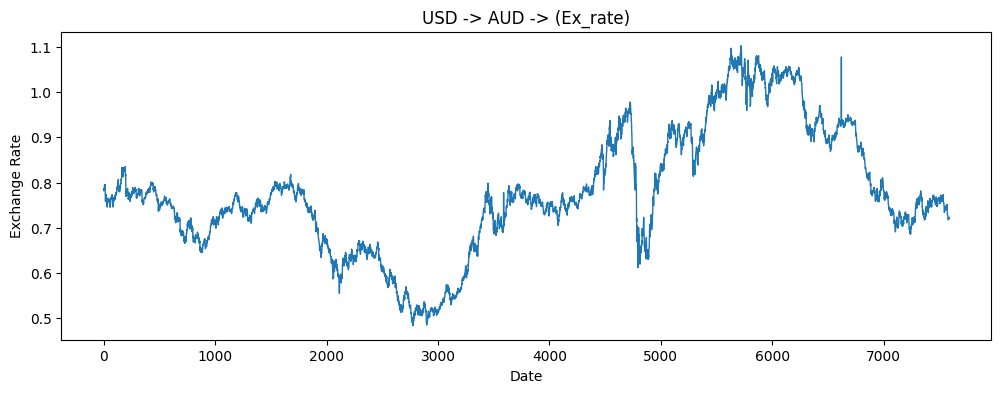

In [84]:
# visualize
plt.figure(figsize=(12,4))
plt.plot(df['Ex_rate'],linewidth=1)
plt.title('USD -> AUD -> (Ex_rate)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

In [103]:
# To Check Missing Values & Cleaning
print("Missing values:")
print(df.isnull().sum())

''' Check for NaNs in the index and remove rows with NaN index
if df.index.isnull().any():
    print("NaN values found in index. Dropping rows with NaN index.")
    df = df[~df.index.isnull()] '''

''' series = df['Ex_rate'].interpolate(method='time').fillna(method='ffill').fillna(method='bfill')

print("\nMissing values after cleaning:")
print(series.isnull().sum()) '''

Missing values:
date       4590
Ex_rate       0
dtype: int64


' series = df[\'Ex_rate\'].interpolate(method=\'time\').fillna(method=\'ffill\').fillna(method=\'bfill\')\n\nprint("\nMissing values after cleaning:")\nprint(series.isnull().sum()) '

In [86]:
# Detect Outliers

q1, q3 = np.percentile(series, [0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = series[(series < lower_bound) | (series > upper_bound)]

print("\nOutliers:",len(outliers))


Outliers: 2917


In [87]:
# ADF Test to decide differencing(d)

adf_stat, pvalues, *_ = adfuller(series.dropna())
print(f'ADF Statistic: {adf_stat}')
print(f'p-value: {pvalues}')


ADF Statistic: -1.6109670062791095
p-value: 0.4774680123411913




*    If p > 0.05 -> Non- Stationary(difference).



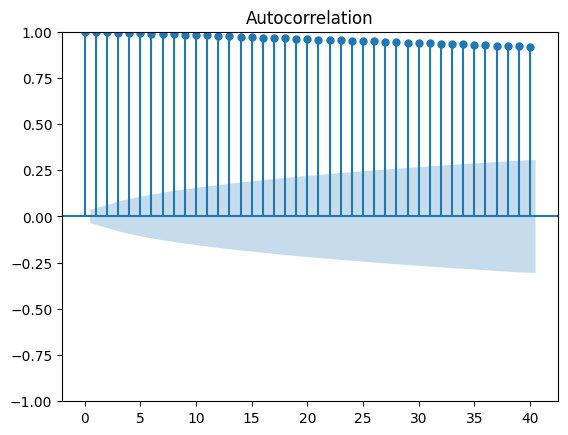

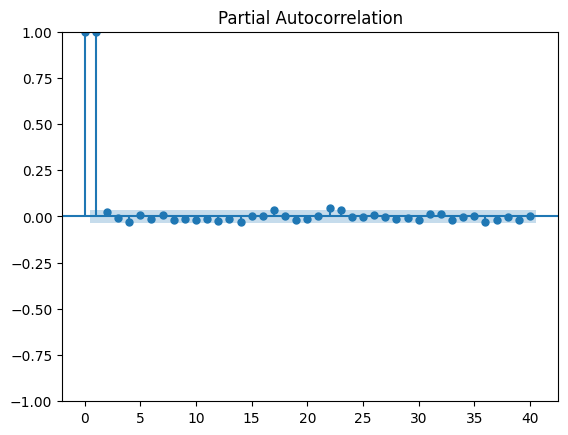

In [88]:
# ACF & PACF
plot_acf(series.dropna(), lags=40); plt.show()
plot_pacf(series.dropna(), lags=40, method='ywm'); plt.show()

- PACF cuts off at lag p -> AR(p) suggested.
- ACF cuts off at lag q -> MA(q) suggested.
- Both decay slowly ->  differencing needed(d >= 1).

In [89]:
!pip install pmdarima

In [90]:
# Train/test split
n = len(series.dropna())
test_size = min(90, max(10, int(0.2 * n)))
train, test = series.dropna()[:-test_size], series.dropna()[-test_size:]


In [91]:
from statsmodels.tsa.arima.model import ARIMA
best_aic = np.inf
best_model = None
best_order = None
for p in range(0,3):
    for d in range(0,3):
        for q in range(0,3):
            try:
                m = ARIMA(train, order=(p,d,q)).fit()
                if m.aic < best_aic:
                    best_aic = m.aic
                    best_model = m
                    best_order = (p,d,q)
            except:
                pass
print("Best order:", best_order)


Best order: (1, 0, 0)


In [92]:
#Exponential Smoothing (Holt-Winters) grid (quick)
period = None
# guess seasonality: if daily and >700 rows => yearality = 365
freq = pd.infer_freq(series.index)
if freq and freq.startswith('D') and len(series) > 700:
    period = 365
elif len(series) > 180:
    period = 30

best_es = None
best_aic = np.inf
for trend in [None, 'add']:
    for seasonal in ([None] if period is None else [None, 'add']):
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=period).fit(optimized=True, use_brute=True)
            if hasattr(model, "aic") and model.aic < best_aic:
                best_aic = model.aic
                best_es = model
        except Exception:
            pass

es_pred = None
if best_es is not None:
    es_pred = best_es.forecast(len(test))

In [93]:
# Evaluation
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan

results = {}
if arima_pred is not None:
    results['ARIMA_MAE'] = mean_absolute_error(test, arima_pred)
    results['ARIMA_MSE'] = mean_squared_error(test, arima_pred)
    results['ARIMA_RMSE'] = np.sqrt(results['ARIMA_MSE']) # Calculate RMSE manually
    results['ARIMA_MAPE'] = mape(test.values, arima_pred.values)

if es_pred is not None:
    results['ES_MAE'] = mean_absolute_error(test, es_pred)
    results['ES_MSE'] = mean_squared_error(test, es_pred)
    results['ES_RMSE'] = np.sqrt(results['ES_MSE']) # Calculate RMSE manually
    results['ES_MAPE'] = mape(test.values, es_pred.values)

print("Evaluation:", results)

Evaluation: {'ARIMA_MAE': 0.025486100322153697, 'ARIMA_MSE': 0.0008167003743336539, 'ARIMA_RMSE': np.float64(0.028577970087703113), 'ARIMA_MAPE': np.float64(3.3741885272480148), 'ES_MAE': 0.028270252359558545, 'ES_MSE': 0.001038967767282857, 'ES_RMSE': np.float64(0.03223302293119367), 'ES_MAPE': np.float64(3.738405217895544)}


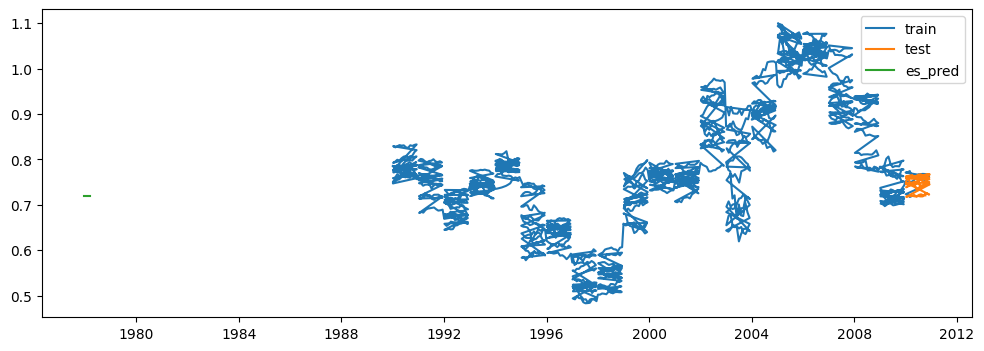

In [94]:
# Plot
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(es_pred.index, es_pred, label='es_pred')
plt.legend(); plt.show()

- Plot ES Pred (MAE, MSE, RMSE, MAPE)  VS actual
- Visual comparison for both ARIMA together.

- **ARIMA:** good for capturing AR/MA structure; needs stationarity (differencing); flexible.

- **Exponential Smoothing:** intuitive, captures level/trend/seasonality directly; faster to fit.

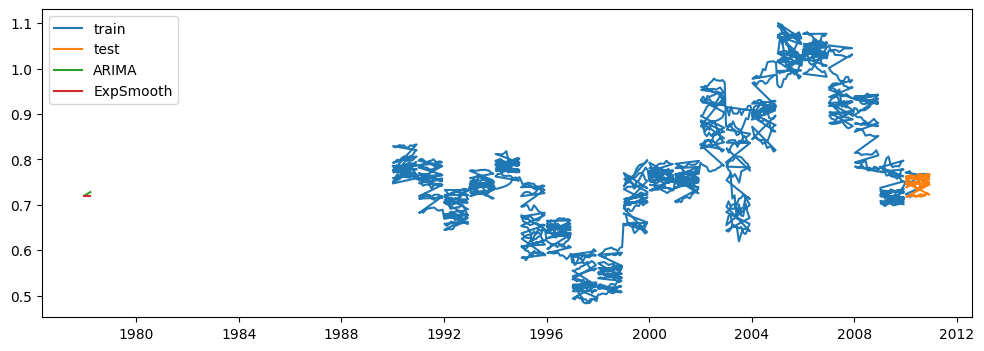

In [95]:
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(arima_pred.index, arima_pred, label='ARIMA')
plt.plot(es_pred.index, es_pred, label='ExpSmooth')
plt.legend(); plt.show()